In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)} # string: integer
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()} # integer: string
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

  # print(w)
  context = [0] * block_size  # [0, 0, 0] (...) for the first character
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]  # crop the 0th character and append the new one

X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [6]:
# build the dataset
import random
block_size = 3  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]  # crop the 0th character and append the new one

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# C is a lookup table that maps each character to vector in 2 dimensional space
C = torch.randn((27, 2)) # 27 characters, 2-dimensional vectors

print(C[5, :]) # 2d vector for character with index 5

# Another way to get a 2d vector for a character is to use one hot encoding for that character
# and then matrix multiply it with the lookup table C. This will plick out the row from the
# lookup table C corresponding to the index of the character.
one_hot = F.one_hot(torch.tensor(5), num_classes=27).float() # one hot vector for character with index 5
# print(one_hot.unsqueeze(0).shape) # [1, 27]
# print(one_hot.shape)  # [1, 27]
# print(C.shape)  # torch.Size([27, 2])
# Matrix multiply -> [1, 27] x  [27, 2] = # [1, 2]

print(one_hot.unsqueeze(0) @ C)  # should be same as C[5]


# So we can interpret this as a lookup into C using the index(integer) of the character or
# we can equivalently also think of it as the first layer of a neural network that takes the one hot
# encoding of the character and outputs a 2d vector whose weight matrix is C. And we are encoding
# integers as one hot vectors and feeding those into the first layer of a neural network. And the
# first layer basically embeds the character into a 2d vector space.


# Indexing multiple characters or integer indices at once
C[[5, 6, 7], :]  # this will give us the 2D vectors for characters with indices 5, 6, and 7

tensor([-0.3256, -0.4487])
tensor([[-0.3256, -0.4487]])


tensor([[-0.3256, -0.4487],
        [ 1.4860,  0.6933],
        [-0.8998,  0.1486]])

In [8]:
# Embedding single integer like 5 is easy --> C[5, :] or one_hot @ C
# But how do we simultaneously embed a whole batch of integers i.e [182625, 3] integers?

# this will give us the 2D vectors for all the integers(3 integers) in each row of X_train
# So each integer out of 3 integers in every row of X_train will be used to index into C
# to get the corresponding 2D vector
print(C[X_train, :].shape)  # torch.Size([182625, 3, 2]) for 182625 rows, 3 characters, and 2D vectors for each character


print(X_train[13, 2])  # tensor(18)

# this will give us the 2D vector for the character with integer 18
print(C[X_train[13, 2], :])  # tensor([1.1501, -0.3578])
print(C[18, :])  # same, tensor([1.1501, -0.3578])


embed = C[X_train, :]  # this will give us the 2D vectors for all the characters in X_train
print(embed.shape)  # torch.Size([182625, 3, 2]) for 182625 rows, 3 characters, and 2D vectors for each character

torch.Size([182625, 3, 2])
tensor(18)
tensor([ 1.0287, -1.9672])
tensor([ 1.0287, -1.9672])
torch.Size([182625, 3, 2])


In [9]:
# 2 is the dimensionality of the vectors we are using to represent each character
# and block_size is the number of characters that we feed into the model at once to predict the next character
W1 = torch.randn((2*block_size, 100))  # 2d vectors for each character, 100 neurons in the first layer
b = torch.randn(100)  # bias for the first layer

print(W1.shape)  # torch.Size([6, 100])

# Since embed is of shape [182625, 3, 2] and W1 is of shape [6, 100], we can
# reshape embed to [182625, 6] and then matrix multiply it with W1
# Xb = embed.view(-1, 2*block_size)  # reshape to [182625, 6]
# print(Xb.shape)  # torch.Size([182625, 6])

# We want is to concatenate the 2D vectors for each character of 3 characters in every example in X_train
# So we want to concatenate the following
# print(embed[:, 0, :].shape) # this will give us the 2D vectors for the first character in each example
# print(embed[:, 1, :].shape) # this will give us the 2D vectors for the second character in each example
# print(embed[:, 2, :].shape) # this will give us the 2D vectors for the third character in each example
# Xb = torch.cat((embed[:, 0, :], embed[:, 1, :], embed[:, 2, :]), dim=1)  # concatenate along the last dimension
# OR
# Xb = torch.cat(torch.unbind(embed, dim=1), dim=1)  # unbind along the second dimension and then concatenate
# torch.unbind(embed, dim=1) returns a tuple of 3 tensors, each tensor is of shape [182625, 2]
# print(Xb.shape)  # torch.Size([182625, 6]) for 182625 rows and 6 columns (2D vectors for each character)

Xb = embed.view(embed.shape[0], -1)  # reshape to [182625, 6]
Xb.shape

torch.Size([6, 100])


torch.Size([182625, 6])

In [10]:
z = Xb @ W1 + b  # matrix multiply and add bias
print(z.shape)  # torch.Size([182625, 100])

torch.Size([182625, 100])


In [11]:
W2 = torch.randn((100, 27))  # 100 neurons in the first layer, 27 characters in the output layer
b = torch.randn(27)  # bias for the output layer

logits = z @ W2 + b  # matrix multiply and add bias
logits.shape  # torch.Size([182625, 27])

torch.Size([182625, 27])

In [12]:
# Calculate the max logit in each row and subtract it from each logit in that row to prevent
# the overflow. Because say a logit is 1000, then exp(1000) will overflow and give us inf and NaN.

# This is a common technique called "log-sum-exp trick" to prevent overflow in softmax calculations.
max_logits = logits.max(dim=1, keepdim=True).values  # get the max logit in each row # torch.Size([182625, 1])
logits = logits - max_logits  # subtract the max logit from each logit in that row
# Now we can safely calculate the exponentials without overflow

counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)  # normalize to get probabilities
probs.shape

torch.Size([182625, 27])

In [16]:
true_label_prob = probs[torch.arange(Xb.shape[0]), Y_train]
print(true_label_prob.shape)  # torch.Size([182625])

loss = -true_label_prob.log().mean()  # negative log likelihood loss
loss

torch.Size([182625])


tensor(inf)

In [14]:
max_logits = logits.max(dim=1, keepdim=True).values
max_logits.shape

torch.Size([182625, 1])

In [36]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
vector_size = 10  # dimensionality of the vectors we are using to represent each character
context_size = 3  # number of characters we take to predict the next one
C = torch.randn((27, vector_size), generator=g)
W1 = torch.randn((context_size * vector_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

total_params = sum(p.nelement() for p in parameters)  # number of parameters in total
print(f'Total number of parameters: {total_params}')

for p in parameters:
  p.requires_grad = True

Total number of parameters: 11897


In [37]:
lre = torch.linspace(-3, 0, 1000) # create a linear space from -3 to 0 with 1000 points
lrs = 10**lre


lri = []
lossi = []
stepi = []


for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,)) # 32 random indices between 0 and the number of training examples.

  # forward pass
  # X_train[[0, 5, 8], :] -> this will give us the 3 rows of X_train with indices 0, 5, and 8 and all columns
  embed = C[X_train[ix], :]  # (32, 3, 10)
  h = torch.tanh(embed.view(-1, 30) @ W1 + b1)  # (32, 200)
  logits = h @ W2 + b2  # (32, 27)

  max_logits = logits.max(dim=1, keepdim=True).values
  logits = logits - max_logits  # subtract the max logit from each logit in that row
  counts = logits.exp()
  probs = counts / counts.sum(dim=1, keepdim=True)  # normalize to get probabilities
  # print(probs.shape)  # torch.Size([32, 27])
  # print(X_train[ix].shape[0])  # 32, number of examples in the minibatch
  # print(Y_train[ix].shape)  # torch.Size([32])
  true_label_prob = probs[torch.arange(X_train[ix].shape[0]), Y_train[ix]]
  loss = -true_label_prob.log().mean()  # negative log likelihood loss


  # OR
  # loss = F.cross_entropy(logits, Y_train[ix])

  # backward pass
  for p in parameters:
    p.grad = None # Zero out the gradients before the backward pass
  # This is important because otherwise gradients will accumulate from previous iterations
  # and we will not get the correct gradients for the current iteration.
  # This is because by default, pytorch accumulates gradients in the .grad attribute of the tensors.
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.4694817066192627


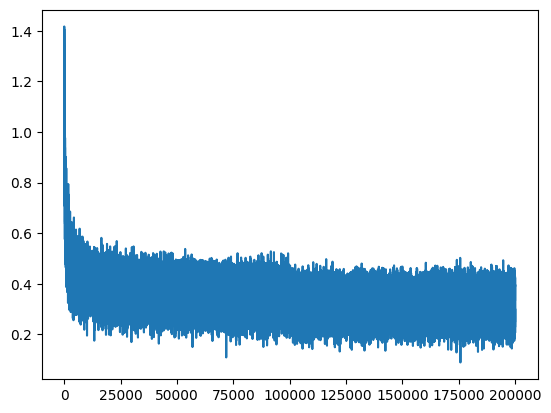

In [38]:
plt.plot(stepi, lossi)

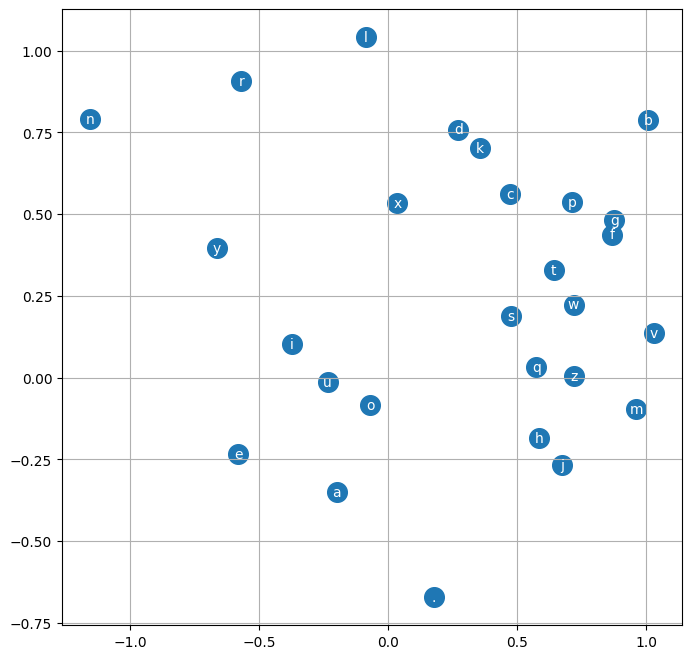

In [34]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha="center", va="center", color='white')
plt.grid('minor')

In [46]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ... [0, 0, 0]
    while True:
      # print(torch.tensor([context]).shape)  # (1, 3) for a single example with 3 characters in the context
      emb = C[torch.tensor([context])]  # (1,block_size,d)
      # print(emb.shape)  # (1, 3, 10)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      # print(h.shape) # (1, 200)
      logits = h @ W2 + b2
      # print(logits.shape)  # (1, 27)
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khy.
mili.
taty.
sacassie.
mahnen.
delynn.
jareen.
nekonia.
chaiiv.
kaleigh.
ham.
join.
quinn.
sulisea.
jadis.
wavero.
dearynix.
kaellinsley.
